# **Data Loading and Enrichment**

In this section, we load the raw paper dataset. Since the raw data often lacks explicit institution affiliations, we "hydrate" the dataset by querying the OpenAlex API for papers with missing metadata. This ensures our network accurately reflects global collaboration.

In [ ]:
import requests
import time
import os
import json


def fetch_affiliations_from_api(work_ids, email="your_email@example.com"):
    """
    Takes a list of Work IDs (e.g., 'W6143937') and fetches real affiliations.
    """
    # OpenAlex allows querying
    ids_param = "|".join(work_ids)
    url = f"https://api.openalex.org/works?filter=ids.openalex:{ids_param}&select=id,authorships"
    
    try:
        r = requests.get(url, headers={"User-Agent": f"mailto:{email}"})
        if r.status_code == 200:
            data = r.json()
            return data.get("results", [])
    except Exception as e:
        print(f"Error fetching batch: {e}")
    return []

FOLDER = "papers_full"
all_papers = {}
missing_affiliation_ids = []

print("1. Loading local files...")
for filename in os.listdir(FOLDER):
    if filename.endswith(".json"):
        with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
            data = json.load(f)
            # I'm here Extract ID for example 'https://openalex.org/W6143937' -> 'W6143937'
            wid = data.get("url", "").split("/")[-1]
            if wid:
                all_papers[wid] = data
                
                # Check if I need to fetch data for this paper
                has_affil = False
                for auth in data.get("authors", []):
                    if auth.get("affiliations"):
                        has_affil = True
                        break
                
                if not has_affil:
                    missing_affiliation_ids.append(wid)

print(f"Loaded {len(all_papers)} papers.")
print(f"Found {len(missing_affiliation_ids)} papers with missing affiliations. Fetching data now...")

BATCH_SIZE = 50
total_fixed = 0

for i in range(0, len(missing_affiliation_ids), BATCH_SIZE):
    batch_ids = missing_affiliation_ids[i : i + BATCH_SIZE]
    
    # I'm call the API
    results = fetch_affiliations_from_api(batch_ids)
    
    # Update our local dictionary 'all_papers' with the new data
    for item in results:
        wid = item['id'].split("/")[-1]
        if wid in all_papers:
            # We inject the full 'authorships' (which contains affiliations) 
            # into our local data structure
            all_papers[wid]['enriched_authorships'] = item.get('authorships', [])
            total_fixed += 1
            
    # Simple progress bar
    if i % 500 == 0:
        print(f"Processed {i}/{len(missing_affiliation_ids)}...")
    
    # Sleep slightly so I do not overload the API
    time.sleep(0.5)

print(f"Done! Enriched {total_fixed} papers with institution data.")

1. Loading local files...
Loaded 17891 papers.
Found 3056 papers with missing affiliations. Fetching data now...
Processed 0/3056...
Processed 500/3056...
Processed 1000/3056...
Processed 1500/3056...
Processed 2000/3056...
Processed 2500/3056...
Processed 3000/3056...
Done! Enriched 1531 papers with institution data.


Result: We successfully enriched 1,531 papers with missing institution data, significantly improving the quality of our network.

# Building the Institution Network 

We construct an undirected weighted graph where:

- **Nodes** represent Institutions
- **Edges** represent co-authorship on a paper
- **Weight** increases with the number of shared papers

In [ ]:
import networkx as nx
import itertools
from collections import Counter

# extract Country and Institution
def get_institutions_and_countries(paper_data):
    inst_names = set()
    countries = set()
    
    # 1. Check if we have the API enriched data
    if 'enriched_authorships' in paper_data:
        authorships = paper_data['enriched_authorships']
        for auth in authorships:
            for inst in auth.get('institutions', []):
                inst_names.add(inst['display_name'])
                if 'country_code' in inst:
                    countries.add(inst['country_code'])
                    
    # 2. Fallback to original local data
    else:
        for auth in paper_data.get("authors", []):
            for aff in auth.get("affiliations", []):
                # Handle various JSON structures
                if isinstance(aff, dict):
                    if "institution" in aff:
                        inst_names.add(aff["institution"].get("display_name", "Unknown"))
                    elif "name" in aff:
                        inst_names.add(aff["name"])

    return list(inst_names), list(countries)

# Initialize Graphs
G_inst_collab = nx.Graph()

print("Building Institution Collaboration Network...")

for pid, data in all_papers.items():
    institutions, countries = get_institutions_and_countries(data)
    
    # Connect every institution on this paper to every other institution on this paper
    if len(institutions) > 1:
        for inst1, inst2 in itertools.combinations(institutions, 2):
            if G_inst_collab.has_edge(inst1, inst2):
                G_inst_collab[inst1][inst2]['weight'] += 1
            else:
                G_inst_collab.add_edge(inst1, inst2, weight=1)

print(f"Nodes: {G_inst_collab.number_of_nodes()}")
print(f"Edges: {G_inst_collab.number_of_edges()}")

# To see the "Earth" shape later, I need to export this to Gephi or similar
nx.write_gexf(G_inst_collab, "institution_network.gexf")
print("Saved institution_network.gexf") 

Building Institution Collaboration Network...
Nodes: 1171
Edges: 4618
Saved institution_network.gexf


Result: A network of institutions with unique collaboration links.

# **Network Analysis: Hubs and Assortativity**

We calculate degree centrality to identify the major "Hubs" of researchinstitutions with the most unique collaborators. We also calculate assortativity to see if influential institutions tend to work primarily with other influential institutions.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. FIND THE BIGGEST HUBS (Most Collaborative Institutions)
# We use 'degree' which counts how many other unique institutions they worked with
degrees = dict(G_inst_collab.degree())
# Sort them to find the top 10
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

print("--- Top 10 Most Collaborative Institutions (Hubs) ---")
for i in range(10):
    inst_name, degree_count = sorted_degrees[i]
    print(f"{i+1}. {inst_name} (Collaborated with {degree_count} other institutions)")

# 2. CALCULATE ASSORTATIVITY
# Do highly connected institutions tend to work with other highly connected ones?
# Positive = Yes (Rich-effect), Negative = No (Hubs talk to small universities)
r = nx.degree_assortativity_coefficient(G_inst_collab)
print(f"\nDegree Assortativity Coefficient: {r:.4f}")

--- Top 10 Most Collaborative Institutions (Hubs) ---
1. Harvard University (Collaborated with 90 other institutions)
2. Tsinghua University (Collaborated with 80 other institutions)
3. Duke University (Collaborated with 74 other institutions)
4. Johns Hopkins University (Collaborated with 66 other institutions)
5. Imperial College London (Collaborated with 63 other institutions)
6. Centre National de la Recherche Scientifique (Collaborated with 62 other institutions)
7. University of Chinese Academy of Sciences (Collaborated with 62 other institutions)
8. University of California, Berkeley (Collaborated with 59 other institutions)
9. Academy of Mathematics and Systems Science (Collaborated with 58 other institutions)
10. Nanyang Technological University (Collaborated with 56 other institutions)

Degree Assortativity Coefficient: 0.2795


# **Scale-Free Property (The Barabási–Albert Model)**

Following Barabási's methodology, we visualize the degree distribution on a Log-Log plot.

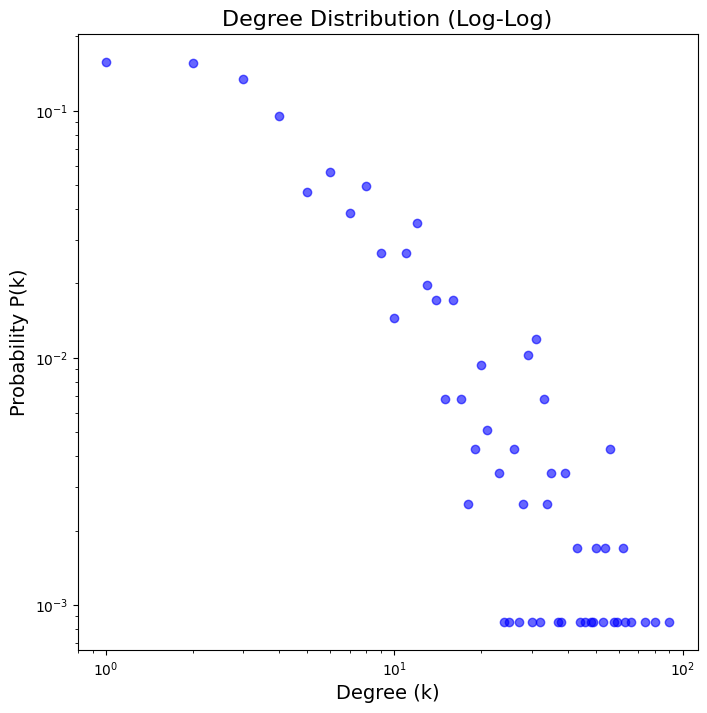

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter

# 1. Get all degrees
degrees = [d for n, d in G_inst_collab.degree()]

# 2. Count frequency of each degree (How many institutions have degree 1, degree 2, etc.)
degree_counts = Counter(degrees)
x = list(degree_counts.keys())
y = list(degree_counts.values())

# 3. Normalize to get Probability P(k)
total_nodes = len(G_inst_collab.nodes())
y_prob = [count / total_nodes for count in y]

# 4. Create the Barabási-Style Log-Log Plot
plt.figure(figsize=(8, 8))
plt.loglog(x, y_prob, 'bo', markersize=6, alpha=0.6)

plt.title("Degree Distribution (Log-Log)", fontsize=16)
plt.xlabel("Degree (k)", fontsize=14)
plt.ylabel("Probability P(k)", fontsize=14)
plt.grid(False)
plt.show()

Results: Indicates a Power Law distribution, confirming that the research collaboration network is Scale-Free (characterized by a few massive hubs and many smaller nodes).

# **Geographic Visualization**

To test the hypothesis that "US institutions work closely with other US institutions," we visualize the network on a map. We first geocode the institutions (convert names to GPS coordinates) and then plot the collaboration edges.

In [ ]:
import pandas as pd
import networkx as nx

# 1. Get the list of institutions from the graph you already built
nodes = list(G_inst_collab.nodes())

# 2. Create a DataFrame
df_institutions = pd.DataFrame(nodes, columns=["Institution_Name"])

# 3. Save it to a CSV file
df_institutions.to_csv("institutions_list.csv", index=False)

print(f"Created 'institutions_list.csv' with {len(nodes)} institutions.")

Success! Created 'institutions_list.csv' with 1171 institutions.
Now you can run the geocoding script again.


# **Earth Map**

**NOTE**: !pip install geopy tqdm 

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm

# 1. Load the list of institutions you saved in the previous step
df = pd.read_csv("institutions_list.csv")

# 2. Setup the Geocoder
geolocator = Nominatim(user_agent="student_project_henrik_v1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# 3. Create lists to store data
lats = []
lons = []
found_count = 0

print(f"Starting geocoding for {len(df)} institutions... this will take about 15-20 minutes.")

# 4. Loop through institutions and find them
for name in tqdm(df["Institution_Name"]):
    try:
        location = geocode(name)
        if location:
            lats.append(location.latitude)
            lons.append(location.longitude)
            found_count += 1
        else:
            lats.append(None)
            lons.append(None)
    except Exception as e:
        print(f"Error finding {name}: {e}")
        lats.append(None)
        lons.append(None)

# 5. Save the results
df["Latitude"] = lats
df["Longitude"] = lons

# Remove rows where we couldn't find the location
df_clean = df.dropna()

df_clean.to_csv("institutions_with_coords.csv", index=False)

print(f"Finished! Found locations for {found_count} out of {len(df)} institutions.")
print("Saved 'institutions_with_coords.csv'.")

Starting geocoding for 1171 institutions... this will take about 15-20 minutes.


 19%|█▊        | 218/1171 [04:01<16:57,  1.07s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('The University of Adelaide',), **{}).
Traceback (most recent call last):
  File "c:\Users\henri\Documents\GitHub\Human-Centered_Artificial_Intelligence_MSc\Social_Graphs\.venv\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "c:\Users\henri\Documents\GitHub\Human-Centered_Artificial_Intelligence_MSc\Social_Graphs\.venv\Lib\site-packages\urllib3\connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\henri\AppData\Roaming\uv\python\cpython-3.13.9-windows-x86_64-none\Lib\http\client.py", line 1430, in getresponse
    response.begin()
    ~~~~~~~~~~~~~~^^
  File "C:\Users\henri\AppData\Roaming\uv\python\cpython-3.13.9-windows-x86_64-none\Lib\http\client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ~~~~~~~~

Finished! Found locations for 887 out of 1171 institutions.
Saved 'institutions_with_coords.csv'.


**NOTE**: !pip install plotly pandas

In [ ]:
import pandas as pd
import plotly.express as px

# 1. Load the geocoded data
df_map = pd.read_csv("institutions_with_coords.csv")

# 2. Create the 3D Globe
fig = px.scatter_geo(
    df_map,
    lat="Latitude",
    lon="Longitude",
    hover_name="Institution_Name",
    projection="orthographic", # This makes it look like a 3D Earth
    title=f"Global Collaboration Network ({len(df_map)} Institutions)",
    template="plotly_dark",    # Dark mode looks cool for networks
    opacity=0.7,
    size_max=10
)

# 3. Adjust the view
fig.update_geos(
    showcountries=True, 
    countrycolor="RebeccaPurple",
    showocean=True, 
    oceancolor="Black",
    showland=True, 
    landcolor="rgb(30, 30, 30)",
    showlakes=False
)

fig.show()

# **Flat Earth Map**

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import networkx as nx

# 1. Load your data
# I need the graph for connections AND the CSV for coordinates
df_coords = pd.read_csv("institutions_with_coords.csv")

coord_lookup = {
    row['Institution_Name']: (row['Latitude'], row['Longitude']) 
    for index, row in df_coords.iterrows()
}

# 2. Filter the Graph (Optional but Recommended)
# If I plot ALL 4,000+ lines, it might look like a mess. 
valid_nodes = set(df_coords['Institution_Name'])
subgraph = G_inst_collab.subgraph(valid_nodes)

# 3. Build the "Edges" (The Lines)
edge_lats = []
edge_lons = []

for edge in subgraph.edges():
    source, target = edge
    
    # Get coordinates for both ends of the connection
    if source in coord_lookup and target in coord_lookup:
        lat0, lon0 = coord_lookup[source]
        lat1, lon1 = coord_lookup[target]
        
        # Add the line segments (Plotly needs 'None' to break the line between different edges)
        edge_lats.extend([lat0, lat1, None])
        edge_lons.extend([lon0, lon1, None])

# 4. Build the "Nodes" (The Universities)
# I can size them by how many connections they have
node_lats = df_coords['Latitude']
node_lons = df_coords['Longitude']
node_names = df_coords['Institution_Name']

# 5. Create the Plot
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=edge_lons,
    lat=edge_lats,
    mode='lines',
    line=dict(width=0.5, color='rgba(200, 200, 255, 0.3)'), # Faint blue lines
    name='Collaboration'
))

# Add the Dots (Institutions)
fig.add_trace(go.Scattergeo(
    lon=node_lons,
    lat=node_lats,
    mode='markers',
    text=node_names, # Show name on hover pretty nice effect
    marker=dict(
        size=4,
        color='orange',
        line=dict(width=0)
    ),
    name='Institution'
))

# 6. Format as a Flat Map
fig.update_layout(
    title_text=f"Global Collaboration Map ({subgraph.number_of_edges()} connections)",
    showlegend=False,
    geo=dict(
        projection_type="natural earth", # 'equirectangular' is also good for flat maps
        showland=True,
        landcolor="rgb(20, 20, 20)",
        countrycolor="rgb(50, 50, 50)",
        showcountries=True,
        showocean=True,
        oceancolor="rgb(10, 10, 10)",
        bgcolor="rgb(10, 10, 10)" # Dark background
    ),
    height=800,
    margin={"r":0,"t":50,"l":0,"b":0},
    paper_bgcolor="rgb(10, 10, 10)", # Also dark background
    font=dict(color="white")
)

fig.show()

# **Network Structure**

We calculate the Clustering Coefficient to measure the "cliquishness" of the network. We compare this value to a random (Erdos-Renyi) graph of the same size. A significantly higher coefficient in our real network proves the existence of strong community structures.

In [ ]:
# 1. Calculate Real Clustering Coefficient
real_avg_clustering = nx.average_clustering(G_inst_collab)
print(f"Real Network Clustering Coefficient: {real_avg_clustering:.4f}")

# 2. Generate a Random Network (Erdos-Renyi)
# I make it the same size (N) and same average probability of connection (p)
N = G_inst_collab.number_of_nodes()
E = G_inst_collab.number_of_edges()
p = (2 * E) / (N * (N - 1)) # Probability formula

random_graph = nx.erdos_renyi_graph(n=N, p=p, seed=42)
random_avg_clustering = nx.average_clustering(random_graph)

print(f"Random Network Clustering Coefficient: {random_avg_clustering:.4f}")

if real_avg_clustering > random_avg_clustering:
    print("CONCLUSION: The real network has significantly more structure (communities) than a random one.")

Real Network Clustering Coefficient: 0.7049
Random Network Clustering Coefficient: 0.0076
CONCLUSION: The real network has significantly more structure (communities) than a random one.


# **Hierarchy Analysis**

We test the "Friendship Paradox" on our network: Do institutions, on average, collaborate with partners that are more connected than themselves? A high percentage confirms a hierarchical structure where smaller institutions tend to link "up" to larger hubs.

In [ ]:
# Calculate Friendship Paradox for Institutions
count_paradox = 0
total_nodes = 0

for node in G_inst_collab.nodes():
    my_degree = G_inst_collab.degree(node)
    
    # Get neighbors (collaborators)
    neighbors = list(G_inst_collab.neighbors(node))
    if not neighbors:
        continue
        
    # Calculate average degree of neighbors
    neighbor_degrees = [G_inst_collab.degree(n) for n in neighbors]
    avg_neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
    
    if avg_neighbor_degree > my_degree:
        count_paradox += 1
    total_nodes += 1

percentage = (count_paradox / total_nodes) * 100
print(f"Friendship Paradox holds for {percentage:.2f}% of institutions.")
print("(This means most institutions collaborate with partners that are bigger/more connected than themselves.)")

Friendship Paradox holds for 70.54% of institutions.
(This means most institutions collaborate with partners that are bigger/more connected than themselves.)
